 <h1><center>Decision Tree Algorithm </center></h1>

#### Disclaimer: this project was part of the course "Machine Learning with Python" from IBM. This project was an ungraded project to prepare for the graded assignments. Due to Coursera policies, the graded assignments cannot be published. Modifications were made in the data extracting and preprocessing as the format of the data source changed.

In this lab exercise, you will learn a popular machine learning algorithm, Decision Tree. You will use this classification algorithm to build a model from historical data of patients, and their response to different medications. Then you use the trained decision tree to predict the class of a unknown patient, or to find a proper drug for a new patient.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#about_dataset">About the dataset</a></li>
        <li><a href="#downloading_data">Downloading the Data</a></li>
        <li><a href="#pre-processing">Pre-processing</a></li>
        <li><a href="#setting_up_tree">Setting up the Decision Tree</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#prediction">Prediction</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#visualization">Visualization</a></li>
    </ol>
</div>
<br>
<hr>

Import the Following Libraries:
<ul>
    <li> <b>numpy (as np)</b> </li>
    <li> <b>pandas</b> </li>
    <li> <b>DecisionTreeClassifier</b> from <b>sklearn.tree</b> </li>
</ul>

In [1]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

<div id="about_dataset">
    <h2>About the dataset</h2>
    Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y. 
    <br>
    <br>
    Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The feature sets of this dataset are Age, Sex, Blood Pressure, and Cholesterol of patients, and the target is the drug that each patient responded to.
    <br>
    <br>
    It is a sample of binary classifier, and you can use the training part of the dataset 
    to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe it to a new patient.
</div>


<div id="downloading_data"> 
    <h2>Downloading the Data</h2>
    To download the data, we will use urllib to download it from IBM Object Storage.
</div>

In [2]:
import csv
import urllib

url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/drug200.csv'
response = urllib.request.urlopen(url)
df = csv.reader(response.read().decode('utf-8').splitlines())

now, read data using pandas dataframe:

In [3]:
my_data = pd.DataFrame(list(df))
new_header = my_data.iloc[0] 
my_data = my_data[1:] 
my_data.columns = new_header

display(my_data.head())

my_data['Age'] = my_data.Age.astype(int)
my_data['Sex'] = my_data.Sex.astype('category')
my_data['BP'] = my_data.BP.astype('category')
my_data['Cholesterol'] = my_data.Cholesterol.astype('category')
my_data['Na_to_K'] = my_data.Na_to_K.astype(float)
my_data['Drug'] = my_data.Drug.astype('category')

my_data.dtypes

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
1,23,F,HIGH,HIGH,25.355,drugY
2,47,M,LOW,HIGH,13.093,drugC
3,47,M,LOW,HIGH,10.114,drugC
4,28,F,NORMAL,HIGH,7.798,drugX
5,61,F,LOW,HIGH,18.043,drugY


0
Age               int32
Sex            category
BP             category
Cholesterol    category
Na_to_K         float64
Drug           category
dtype: object

<div id="practice"> 
    <h3>Practice</h3> 
    What is the size of data? 
</div>

In [4]:
# write your code here
my_data.shape

(200, 6)

<div href="pre-processing">
    <h2>Pre-processing</h2>
</div>

Using <b>my_data</b> as the Drug.csv data read by pandas, declare the following variables: <br>

<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (data of my_data) </li>
    <li> <b> y </b> as the <b> response vector (target) </b> </li>
</ul>

Remove the column containing the target name since it doesn't contain numeric values.

In [5]:
X = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

As you may figure out, some features in this dataset are categorical such as __Sex__ or __BP__. Unfortunately, Sklearn Decision Trees do not handle categorical variables. But still we can convert these features to numerical values. __pandas.get_dummies()__
Convert categorical variable into dummy/indicator variables.

In [6]:
from sklearn import preprocessing
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]


array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

Now we can fill the target variable.

In [7]:
y = my_data["Drug"]
y[0:5]

1    drugY
2    drugC
3    drugC
4    drugX
5    drugY
Name: Drug, dtype: category
Categories (5, object): [drugA, drugB, drugC, drugX, drugY]

<hr>

<div id="setting_up_tree">
    <h2>Setting up the Decision Tree</h2>
    We will be using <b>train/test split</b> on our <b>decision tree</b>. Let's import <b>train_test_split</b> from <b>sklearn.cross_validation</b>.
</div>

In [8]:
from sklearn.model_selection import train_test_split

Now <b> train_test_split </b> will return 4 different parameters. We will name them:<br>
X_trainset, X_testset, y_trainset, y_testset <br> <br>
The <b> train_test_split </b> will need the parameters: <br>
X, y, test_size=0.3, and random_state=3. <br> <br>
The <b>X</b> and <b>y</b> are the arrays required before the split, the <b>test_size</b> represents the ratio of the testing dataset, and the <b>random_state</b> ensures that we obtain the same splits.

In [9]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

Print the shape of X_trainset and y_trainset. Ensure that the dimensions match

In [10]:
# print shape
print(X_trainset.shape, y_trainset.shape)

(140, 5) (140,)


Print the shape of X_testset and y_testset. Ensure that the dimensions match

In [11]:
# print shape
print(X_testset.shape, y_testset.shape)


(60, 5) (60,)


<hr>

<div id="modeling">
    <h2>Modeling</h2>
    We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>drugTree</b>.<br>
    Inside of the classifier, specify <i> criterion="entropy" </i> so we can see the information gain of each node.
</div>

In [12]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

Next, we will fit the data with the training feature matrix <b> X_trainset </b> and training  response vector <b> y_trainset </b>

In [13]:
drugTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

<hr>

<div id="prediction">
    <h2>Prediction</h2>
    Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <b>predTree</b>.
</div>

In [14]:
predTree = drugTree.predict(X_testset)

You can print out <b>predTree</b> and <b>y_testset</b> if you want to visually compare the prediction to the actual values.

In [15]:
print (predTree [0:5])
print (y_testset [0:5])


['drugY' 'drugX' 'drugX' 'drugX' 'drugX']
41     drugY
52     drugX
140    drugX
198    drugX
171    drugX
Name: Drug, dtype: category
Categories (5, object): [drugA, drugB, drugC, drugX, drugY]


<hr>

<div id="evaluation">
    <h2>Evaluation</h2>
    Next, let's import <b>metrics</b> from sklearn and check the accuracy of our model.
</div>

In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.9833333333333333


__Accuracy classification score__ computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.  

In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.


<hr>

<div id="visualization">
    <h2>Visualization</h2>
    Lets visualize the tree
</div>

In [17]:
from io import StringIO
import pydotplus
import pydot
import matplotlib.image as mpimg
from sklearn import tree
from IPython.display import Image
%matplotlib inline 

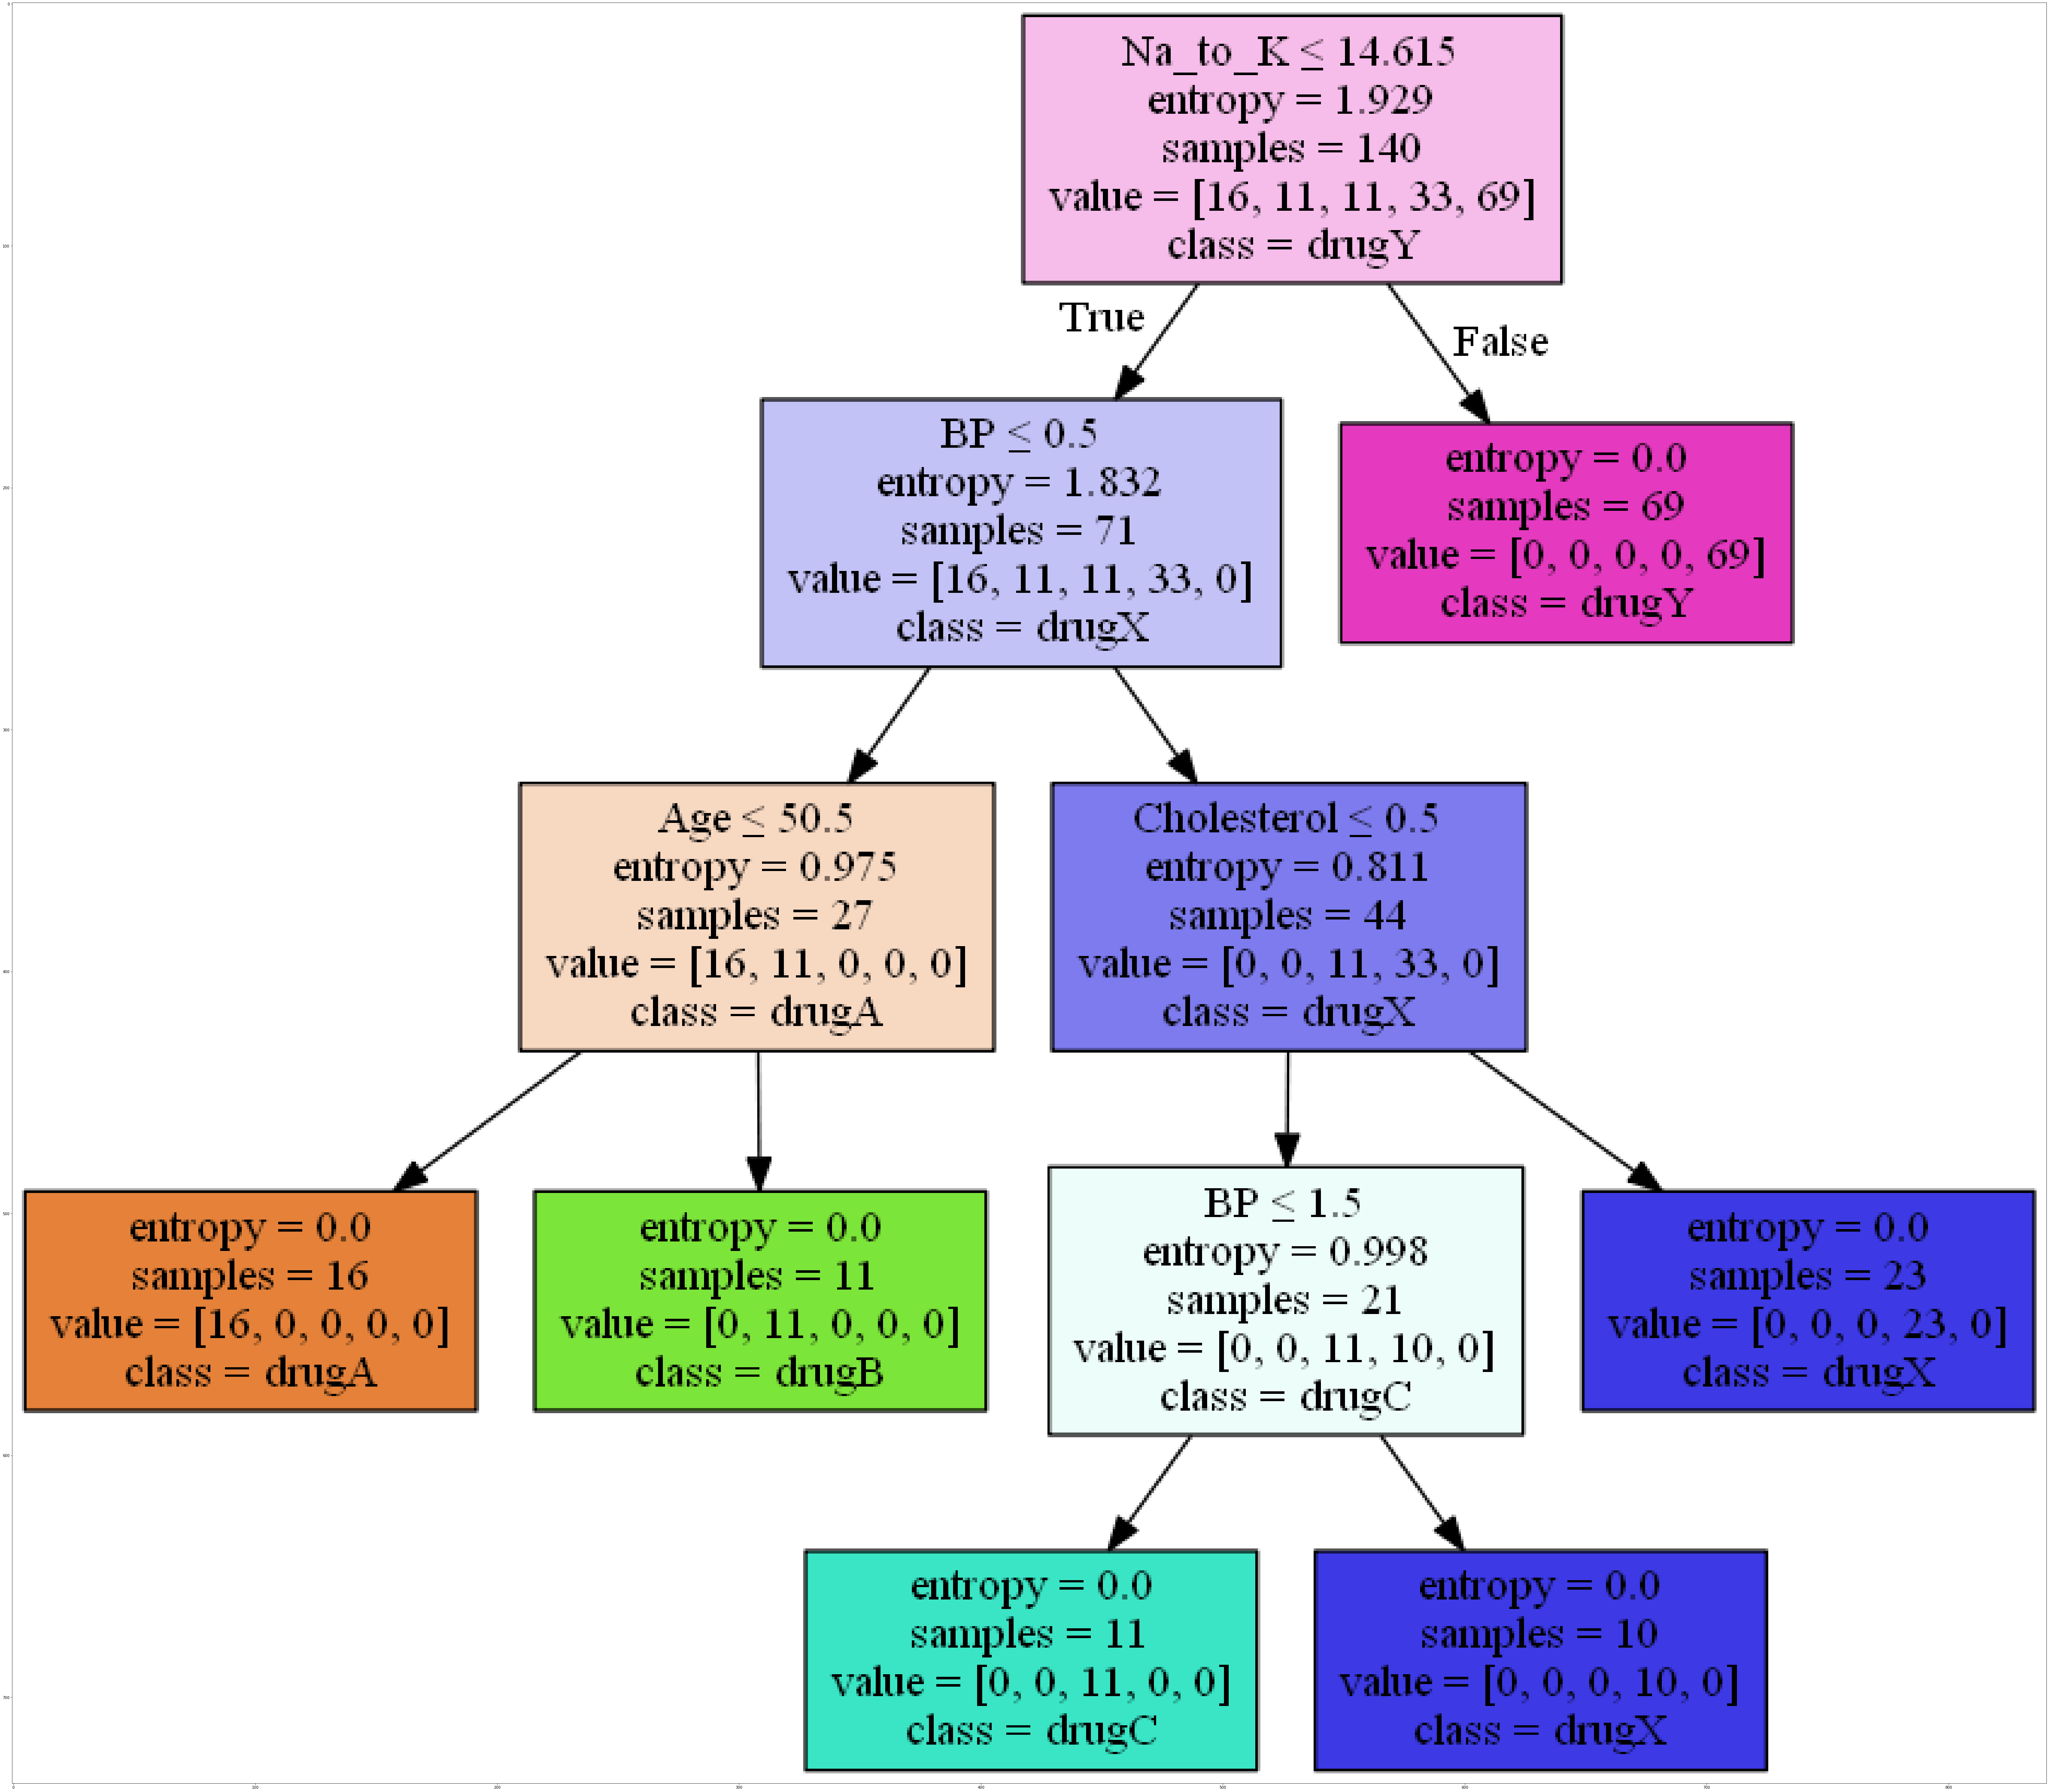

In [18]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = my_data.columns[0:5]
targetNames = my_data["Drug"].unique().tolist()

tree.export_graphviz(drugTree,
                     feature_names=featureNames, 
                     out_file=dot_data, 
                     class_names= np.unique(y_trainset), 
                     filled=True,  
                     special_characters=True,
                     rotate=False)  

(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
#Image(graph.create_png('drugtree.png'))
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

Copyright © 2018 Cognitive Class. This notebook and its source code are released under the terms of the MIT License.